In [148]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [149]:
graph=nx.read_edgelist('graph.txt',nodetype=int)

In [150]:
print(type(graph))

<class 'networkx.classes.graph.Graph'>


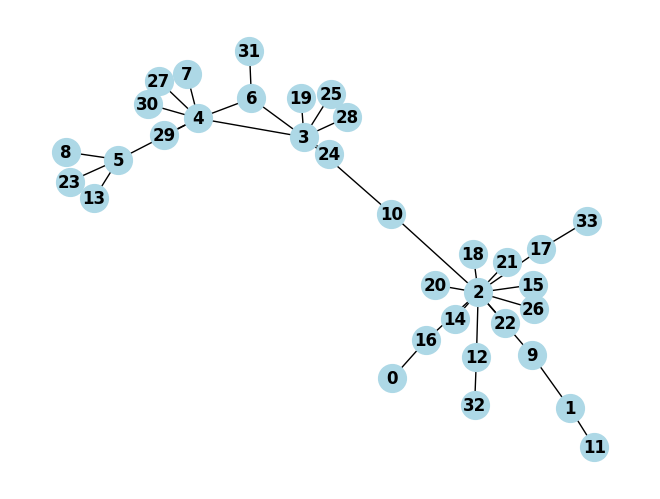

In [151]:
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=400, font_size=12, font_color='black', font_weight='bold')
plt.show()

In [152]:
def findNeighborEdges(graph,edge):
    neighborEdges = [(edge[0],neighbor) for neighbor in graph.neighbors(edge[0])] + [(edge[1],neighbor) for neighbor in graph.neighbors(edge[1])]
    return [i for i in neighborEdges if (i!=edge and i!=edge[::-1])]

# def initializePopulation(graph):

In [ ]:
class individual:
    def __init__(self, m, communities):
        self.size = 

In [153]:
communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(graph))
communities

[{0, 16},
 {1, 11},
 {2, 9, 14, 15, 18, 20, 21, 22, 26},
 {3, 10, 19, 24, 25, 28},
 {6, 31},
 {4, 7, 27, 29, 30},
 {5, 8, 13, 23},
 {12, 32},
 {17, 33}]

In [157]:
def most_frequent_label(labels, graph, v):
    neighbors_of_v = list(graph.neighbors(v))
    max_value = max(labels[key] for key in neighbors_of_v)
    max_keys = [key for key in neighbors_of_v if labels[key] == max_value]
    return random.choice(max_keys)

def node_to_edge_community(labels,graph):
    communities={}
    for edge in graph.edges():
        u, v = edge
        if labels[u] == labels[v]:
            community=labels[u]
        else : 
            community = random.choice([labels[u],labels[v]])
        if community in communities:
            communities[community].add(edge)
        else : communities[community] ={edge}
    return [value_set for value_set in communities.values()]

def label_propagation(graph):
    stop = False
    labels = {node: node for node in graph.nodes()}
    while not stop:
        stop = True
        shuffled_nodes = list(graph.nodes())
        random.shuffle(shuffled_nodes)
        for v in shuffled_nodes:
            current = labels[v]
            labels[v] = most_frequent_label(labels, graph, v)

            if labels[v] != current:
                stop = False

    communities=node_to_edge_community(labels,graph)
    return communities
    
    

label_propagation(graph)

[{(0, 16)},
 {(1, 9), (2, 10), (2, 15), (2, 18), (2, 20), (12, 32), (16, 2)},
 {(1, 11)},
 {(2, 12), (2, 14), (2, 17), (2, 21), (2, 22), (2, 26), (9, 2), (17, 33)},
 {(3, 4),
  (3, 6),
  (3, 24),
  (4, 5),
  (4, 7),
  (4, 27),
  (4, 30),
  (6, 4),
  (6, 31),
  (10, 3)},
 {(3, 19), (3, 25), (3, 28)},
 {(4, 29), (5, 8), (5, 13), (5, 23)}]

In [158]:
#local expansion
def natural_community(graph, seed):
    nodes = list(graph.neighbors(seed)) + [seed]
    res = graph.subgraph(nodes)
    return res


def local_expansion(graph):
    communities = {}
    counter = 0
    # degrees=dict(graph.degree())
    # visited = [[node,0] for node in sorted(degrees, key = lambda x : degrees[x], reverse = True)] #visited array sorted by degrees
    shuffled_nodes = list(graph.nodes())
    random.shuffle(shuffled_nodes)
    visited = {node: 0 for node in shuffled_nodes}
    labels = {node: node for node in graph.nodes()}
    for seed in shuffled_nodes:
        if visited[seed]:
            continue
        visited[seed] = 1
        nat_com = natural_community(graph, seed)
        for node in list(nat_com.nodes()):
            labels[node] = seed
    communities = node_to_edge_community(labels, graph)
    print(communities)
    return communities


local_expansion(graph)


[{(16, 2), (0, 16)}, {(9, 2), (1, 9)}, {(1, 11)}, {(3, 24), (3, 4), (2, 20), (2, 10), (3, 19), (2, 22), (2, 12), (10, 3), (3, 28), (2, 15)}, {(2, 14)}, {(17, 33), (2, 17)}, {(2, 18)}, {(2, 21)}, {(2, 26)}, {(6, 31), (6, 4), (3, 6)}, {(3, 25)}, {(4, 29), (4, 7), (4, 5), (4, 27), (4, 30)}, {(5, 13), (5, 8)}, {(5, 23)}, {(12, 32)}]


[{(0, 16), (16, 2)},
 {(1, 9), (9, 2)},
 {(1, 11)},
 {(2, 10),
  (2, 12),
  (2, 15),
  (2, 20),
  (2, 22),
  (3, 4),
  (3, 19),
  (3, 24),
  (3, 28),
  (10, 3)},
 {(2, 14)},
 {(2, 17), (17, 33)},
 {(2, 18)},
 {(2, 21)},
 {(2, 26)},
 {(3, 6), (6, 4), (6, 31)},
 {(3, 25)},
 {(4, 5), (4, 7), (4, 27), (4, 29), (4, 30)},
 {(5, 8), (5, 13)},
 {(5, 23)},
 {(12, 32)}]

In [156]:
def initializePopulation(graph):

SyntaxError: incomplete input (3419092578.py, line 1)

In [ ]:
def decode(individual):


[0, 2]

In [ ]:
communities= {16: {(0, 16)},
 14: {(2, 14), (2, 17), (2, 18), (2, 20), (2, 22), (2, 26), (16, 2)},
 11: {(1, 9), (1, 11)},
 1: {(9, 2)},
 3: {(2, 10), (10, 3)},
 12: {(2, 12), (12, 32)},
 15: {(2, 15)},
 21: {(2, 21)},
 24: {(3, 6), (3, 19), (3, 24), (3, 25)},
 4: {(3, 4), (4, 5), (4, 7), (4, 27), (4, 29), (4, 30), (5, 8)},
 28: {(3, 28)},
 31: {(6, 4), (6, 31)},
 13: {(5, 13)},
 5: {(5, 23)},
 17: {(17, 33)}}

# # communities.values()
# for community in communities.values():
#     for edge in community:
#             print(edge)

In [ ]:
#Link Partition Density
def fitness(graph, communities):
    ans = 0
    for community in communities.values():
        m = len(community)
        
        nodes = set()
        for edge in community:
            nodes.add(edge[0])
            nodes.add(edge[1])
        n = len(nodes)
        print(m,nodes)
        if(n < 3):
            continue
        ans += (m*((m-(n-1))/((n-1)*(n-2))))
    ans *= (len(communities)/graph.number_of_edges())
    return ans
fitness(graph,communities)

1 {0, 16}
7 {2, 14, 16, 17, 18, 20, 22, 26}
2 {1, 11, 9}
1 {9, 2}
2 {3, 2, 10}
2 {32, 2, 12}
1 {2, 15}
1 {2, 21}
4 {3, 6, 19, 24, 25}
7 {3, 4, 5, 7, 8, 27, 29, 30}
1 {3, 28}
2 {4, 6, 31}
1 {13, 5}
1 {5, 23}
1 {17, 33}


0.0

In [ ]:
def m_link(adj, lsp=0.5, cp=0.5, mp=0.5):
    treePopulation = initializePopulation(adj)
    evaluate(treePopulation)

    while termination :
        for a in treePopulation:
            parent1 = selectIndividualFrom(a)
            
            if notLostDiversity():
                parent2 = closeSelect(a)
            else:
                parent2 = farSelect(a)
            
            offspring = crossover(parent1, parent2, cp)
            mutate(offspring)

            if (random.uniform(0,1) < lsp):
                localSearch(offspring)
            
            updatePopulation(offspring)
            
    overlappingCommunities = postProcessing(getBest(treePopulation))